In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

### **Environment**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self, n = 3, is_stochastic = False, random_start = False):
        self.observation_space = spaces.Discrete(n ** 2)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 3 * n + 1
        self.is_stochastic = is_stochastic
        self.n = n
        self.random_start = random_start

        # defining stochastic environment such that ∑P_i = 1
        if self.is_stochastic:
            self.transition_prob = []
            for i in range(n):
                x = []
                for j in range(n):
                    y = []
                    for action in range(self.action_space.n):
                        z = [.1] * self.action_space.n
                        z[action] = .7
                        y.append(z)
                        x.append(y)
                self.transition_prob.append(x)
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.zeros(2, dtype = int)
        if self.random_start:
            self.agent_pos = np.random.randint(self.n, size = 2)
        self.goal_pos = [self.n - 1, self.n - 1]
        self.monster_pos = [self.n // 2, self.n // 2]
        self.update_state()
        self.prev_distance = self.get_distance(self.agent_pos, self.goal_pos)
        observation = self.agent_pos
        return self.createState(observation)
    
    # creating state for neural network as per one hot encoding
    def createState(self, obs):
        one_hot = torch.zeros((1, self.observation_space.n), device = device)
        one_hot[0, (self.n * obs[0]) + obs[1]] = 1
        return one_hot

    def update_state(self):
      self.state = np.zeros((self.n, self.n))
      self.state[tuple(self.goal_pos)] = 0.5
      self.state[tuple(self.monster_pos)] = 0.25
      self.state[tuple(self.agent_pos)] = 1

    def get_action(self, x, y, action):
        return np.random.choice(self.action_space.n, p = self.transition_prob[x][y][action])

    def get_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def step(self, action):
        if self.is_stochastic:
            action = self.get_action(self.agent_pos[0], self.agent_pos[1], action)

        # top-left: (0, 0)
        if action == 0: #down
            self.agent_pos[0] += 1
        if action == 1: #up
            self.agent_pos[0] -= 1
        if action == 2: #right
            self.agent_pos[1] += 1
        if action == 3: #left
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.n - 1)
        self.update_state()
        observation = self.agent_pos
        
        reward = 0
        current_distance = self.get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        else:
            reward = -1
        self.prev_distance = current_distance

        goal_reached = (self.agent_pos == self.goal_pos).all()
        if goal_reached:
            reward = 10

        found_monster = (self.agent_pos == self.monster_pos).all()
        if found_monster:
            reward = -10
        
        self.timestep += 1
        done = True if (self.timestep >= self.max_timesteps) or goal_reached or found_monster else False
        info = {}
        
        return self.createState(observation), reward, done, info
        
    def render(self):
        plt.imshow(self.state)
        plt.show()

### **Actor and Crtic Networks**

In [3]:
class Actor(nn.Module):
    def __init__(self, inputs, outputs):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), -1)
        return x

class Critic(nn.Module):
    def __init__(self, inputs, outputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
  

### **TD Actor Critic Agent**

In [19]:
class Agent:
    def __init__(self, env, lr = 0.01, gamma = 0.999):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.gamma = gamma

        self.actor = Actor(self.observation_space.n, self.action_space.n).to(device)
        self.critic = Critic(self.observation_space.n, 1).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr = lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr = lr)

        self.critic_criterion = nn.MSELoss()

    # ref: https://pytorch.org/docs/stable/distributions.html
    def step(self, state):
        probs = self.actor(state)
        state_val = self.critic(state)
        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action, log_prob, state_val

    def calculate_returns(self, rewards):
        returns = []
        curr = 0
        for r in reversed(rewards):
            curr = r + self.gamma * curr
            returns.append(curr)
        return torch.tensor(returns[::-1])
        
    def update(self, values, log_probs, rewards):
        returns = self.calculate_returns(rewards)
        actor_loss = []
        critic_loss = []

        for value, log_prob, R in zip(values, log_probs, returns):
            advantage = R - value.item()
            # Actor loss
            actor_loss.append(-1 * log_prob * advantage)
            # Crtic loss
            critic_loss.append(self.critic_criterion(torch.tensor([R], device = device).unsqueeze(1), value).unsqueeze(0))

        # Actor loss backprop
        self.actor_optimizer.zero_grad()
        actor_loss = torch.cat(actor_loss).mean()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Critic loss backprop
        self.critic_optimizer.zero_grad()
        critic_loss = torch.cat(critic_loss).mean()
        critic_loss.backward()
        self.critic_optimizer.step()

    def test(self):
        state = self.env.reset()
        done = False
        self.env.render()
        while not done:
            with torch.no_grad():
                action = self.actor(state).max(1)[1].view(1, 1)
            obs, reward, done, info = self.env.step(action)
            state = obs
            self.env.render()
    
    def saveWeights(self, path):
        torch.save(self.actor.state_dict(), path + '_actor')
        torch.save(self.critic.state_dict(), path + '_critic')

    def loadWeights(self, path):
        self.actor.load_state_dict(torch.load(path + '_actor'))
        self.critic.load_state_dict(torch.load(path + '_critic'))


### **MDP**

10 episode completed. Reward: 0
20 episode completed. Reward: 2
30 episode completed. Reward: -7
40 episode completed. Reward: 2
50 episode completed. Reward: 17
60 episode completed. Reward: 17
70 episode completed. Reward: 17
80 episode completed. Reward: 17
90 episode completed. Reward: 14
100 episode completed. Reward: 17
110 episode completed. Reward: 17
120 episode completed. Reward: 17
130 episode completed. Reward: 17
140 episode completed. Reward: 17
150 episode completed. Reward: 17
160 episode completed. Reward: 17
170 episode completed. Reward: 17
180 episode completed. Reward: 17
190 episode completed. Reward: 17
200 episode completed. Reward: 17
210 episode completed. Reward: 17
220 episode completed. Reward: 17
230 episode completed. Reward: 17
240 episode completed. Reward: 17
250 episode completed. Reward: 16
260 episode completed. Reward: 17
270 episode completed. Reward: 17
280 episode completed. Reward: 17
290 episode completed. Reward: 17
300 episode completed. Rew

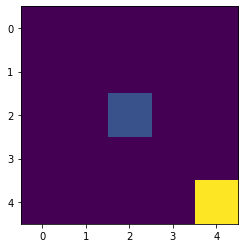

In [21]:
env = GridEnvironment(5)
agent = Agent(env)

steps = 0
total_rewards = []
episodes = 500

for episode in range(episodes):
    state = env.reset()
    done = False
    
    state_values = []
    log_probs = []
    rewards = []

    curr_reward = 0

    while not done:
        action, log_prob, state_val = agent.step(state)
        state_values.append(state_val)
        log_probs.append(log_prob)
        next_state, reward, done, info = env.step(action.item())
        curr_reward += reward
        rewards.append(reward)

        state = next_state
        steps += 1
    
    agent.update(state_values, log_probs, rewards)
    
    total_rewards.append(curr_reward)
    if (episode + 1) % 10 == 0:
        print(f'{episode + 1} episode completed. Reward: {curr_reward}')

print('Complete')
print(f'On Average {steps / episodes} steps per episode\n')
env.render()

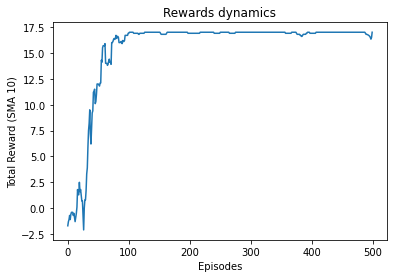

In [22]:
step = 10
plt.title('Rewards dynamics')
plt.xlabel('Episodes')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[i : i + step]) for i in range(len(total_rewards))])
plt.savefig('Rewards_dynamics.png')

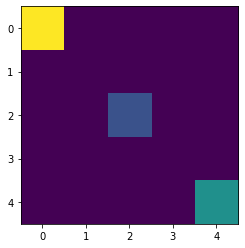

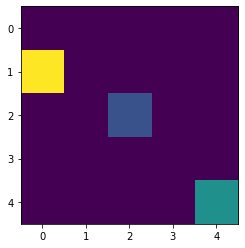

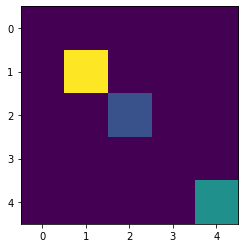

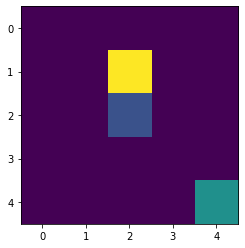

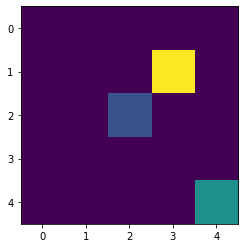

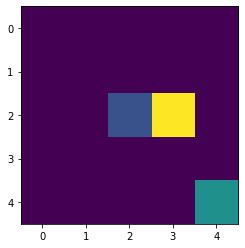

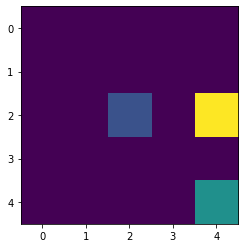

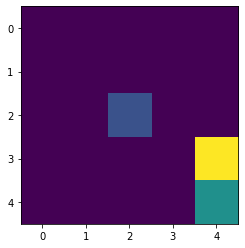

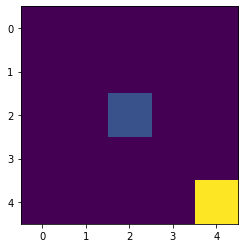

In [122]:
agent.test()